In [17]:
###Installing our package which contains fuctions, class, datasets and documentation

In [18]:
pip install -i https://test.pypi.org/simple/ IES-Project-Covid10==1

Looking in indexes: https://test.pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Importing module downloader

from app import downloader as d

#Loading token from token1, token1 is in .gitignore file, so it is not on github

from token1 import token

In [2]:
#Initializing class Covid_Data, the file path for documentation will change after you download the package
#and initialize class Covid_Data

covid = d.Covid_Data()

Class initialize, if you want to load data provided by this package - use method load_data() or you can download it on your own using method download(*args, *kwargs) You can access documentation at: /Users/Jakub/opt/anaconda3/lib/python3.8/site-packages/app/docs/_build/html/index.html
No data loaded or downloaded.


In [3]:
#Loading dataset that is part of the package

covid.load_data()

Data loaded


In [4]:
#Obataining information about the loaded dataset

covid.get_info()
covid.info

{'total cases': 2446832, 'start_date': '01.03.2020', 'end_date': '24.12.2021'}

In [5]:
#Checking how many pages were downloaded 

covid.get_page(token)

You downloaded 490 pages out of total 490 pages. 
 To upadte your dataset to today daate you need to get total: 647 pages


False

In [6]:
#Loading module scraper

from app import scraper

In [411]:
#Using the function from module scraper to scrape czech statistical office

district_pop = scraper.get_district_pop()
district_pop

,Total,Men,Women
Česká republika,10694480,5270358,5424122
Praha,1337074,654927,682147
Střední Čechy,1400879,693318,707561
Jihozápad,1233364,610843,622521
Severozápad,1107303,548415,558888
...,...,...,...
Frýdek-Místek,214517,105684,108833
Karviná,241919,117970,123949
Nový Jičín,151330,74656,76674
Opava,175570,85933,89637


In [10]:
import pandas as pd
import geopandas

In [53]:
#Loading map files to create a map graph

link_dist = "/Users/Jakub/opt/anaconda3/lib/python3.8/site-packages/app/data/map/PolbndDistDA.shp"
districts = geopandas.read_file(link_dist)

#Map for Prague is not part of districts, but regions
link_reg = "/Users/Jakub/opt/anaconda3/lib/python3.8/site-packages/app/data/map/PolbndRegDA.shp"
regions = geopandas.read_file(link_reg)

prague = regions.iloc[5]

In [54]:
### We performe some adjustments so the merge with covid data is smooth. We will be merging on column "district_code" 

#droping useless columns and renaming similar columns to same names
prague = prague.drop(labels = ["REG_LABEL", "ANND"]).rename({"SHN1":"okres_lau_kod"})

districts = districts.rename(columns = {"SHN2":"okres_lau_kod"})

#appending Prague to all districts
districts = districts.append(prague).drop(columns = ["DESN", "ISN", "F_CODE", "FCSUBTYPE"]).set_index("NAMN")

#for loop to get the distric codes in desired format
for i in range(78):
    districts["okres_lau_kod"][i] = districts["okres_lau_kod"][i][:6]
    
#merging districts data with scraped population of districts
map_dataset = districts.merge(district_pop, left_on = "NAMN", right_index = True, how = "left")

<ipython-input-54-77ce30a096a3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  districts["okres_lau_kod"][i] = districts["okres_lau_kod"][i][:6]


In [167]:
import matplotlib.pyplot as plt
from IPython.display import display

In [308]:
def plot_district_infec(start, end, table = False, show = "Total"):
    """
    Plots several options of infections in Czech Republic districts 
    
    Parameters
    --------
    start (str): Start date, in format YYYY-MM-DD
    
    end(str): End date, in format YYYY-MM-DD
    
    day (str): Specifies day for which it will be shown, in format YYYY-MM-DD
    
    table (boolean): Print table of districts, default is set to False
    
    show (str): 4 possible values: "Total" - shows total infections in district, "Rel" - shows infections per 100 000 people
    in the district, "M/W" - shows ratio of men and women infecitons in districts relative to districts men and woman population
    
    Return
    -------
    table (optional)
    """
    period_dates = pd.date_range(start, end, freq='D')
    period = covid.data[covid.data["datum"].isin(period_dates.astype(str).tolist())]
    infections = period.groupby(["okres_lau_kod"]).count()
    table_dist_infec = infections.reset_index()[["okres_lau_kod", "id"]]
    plot_data = map_dataset.merge(table_dist_infec, on = "okres_lau_kod", how = "outer").reset_index()
    plot_data['id'] = plot_data['id'].fillna(0)
    
    if show == "Total":
        fig, ax = plt.subplots(1, 1)
        plot_data.plot("id", ax=ax, legend=True).set_axis_off()
        title = "Number of infections"
        plt.title(title)
    
    if show == "Rel":
        plot_data["id"] = plot_data["id"]/plot_data["Total"].astype(int) * 100000
        fig, ax = plt.subplots(1, 1)
        plot_data.plot("id", ax=ax, legend=True).set_axis_off()
        title = "Relative infections per 100 000 people"
        plt.title(title)
    
    if show == "M/W":
        period_men = period[period["pohlavi"] == "M"]
        period_women = period[period["pohlavi"] == "Z"]
        infections_men = period_men.groupby(["okres_lau_kod"]).count().reset_index()[["okres_lau_kod", "id"]]
        infections_women = period_women.groupby(["okres_lau_kod"]).count().reset_index()[["okres_lau_kod", "id"]]
        table_dist_infec = infections_men.merge(infections_women, on = "okres_lau_kod", how = "outer")
        plot_data = map_dataset.merge(table_dist_infec, on = "okres_lau_kod", how = "outer").reset_index()
        plot_data['id_x'] = plot_data['id_x'].fillna(0)
        plot_data['id_y'] = plot_data['id_y'].fillna(0)
        rel_w = plot_data["id_y"]/plot_data["Women"].astype(int)
        rel_m = plot_data["id_x"]/plot_data["Men"].astype(int)
        plot_data["id"] = rel_m/(rel_m+rel_w)
        plot_data['id'] = plot_data['id'].fillna(0.5)
        fig, ax = plt.subplots(1, 1)
        plot_data.plot("id", ax=ax, legend=True).set_axis_off()
        title = "Men to Women ratio"
        plt.title(title)
        
    if table:
        table = plot_data.sort_values(by = ["id"], ascending=False)[["NAMA", "id"]].rename(columns = {"NAMA" : "District", "id" : title})
        table = table.set_index("District")
        display(table)
        return table
    
        
        
   

,Men to Women ratio
District,
Karvina,0.511383
Plzen-mesto,0.507834
Hlavni mesto Praha,0.507175
Brno-mesto,0.506832
Sokolov,0.505607
...,...
Litomerice,0.478211
Litomerice,0.478211
Tachov,0.475269


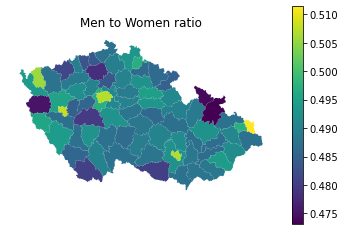

In [285]:
men_to_women = plot_district_infec(start = "2020-03-01", end = "2021-12-24", show = "M/W", table = True)

In [288]:
more_men = men_to_women[men_to_women["Men to Women ratio"] > 0.5]
more_men

,Men to Women ratio
District,
Karvina,0.511383
Plzen-mesto,0.507834
Hlavni mesto Praha,0.507175
Brno-mesto,0.506832
Sokolov,0.505607


In [289]:
more_women = men_to_women[men_to_women["Men to Women ratio"] < 0.5]
more_women

,Men to Women ratio
District,
Ostrava-mesto,0.497430
Praha-zapad,0.497347
Jablonec nad Nisou,0.497235
Domazlice,0.495647
Plzen-sever,0.495353
...,...
Litomerice,0.478211
Litomerice,0.478211
Tachov,0.475269


In [303]:
print("In only " + str(round(len(more_men)/len(more_women)*100,2)) + " % districts more men than women were infected.")

In only 6.85 % districts more men than women were infected.


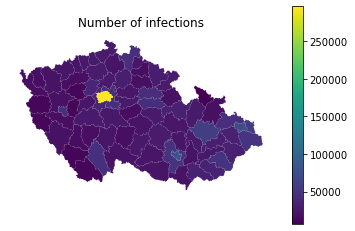

In [326]:
plot_district_infec(start = "2020-03-01", end = "2021-12-24", show = "Total")

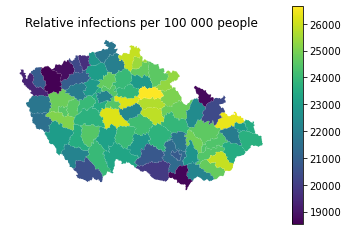

In [327]:
plot_district_infec(start = "2020-03-01", end = "2021-12-24", show = "Rel")

We can notice that Prague is the leader in total cases, however if we look on the relative cases per 100 000 people, the picture is quite different.

In [424]:
### Computing mean age of infected persons for each day

#creating a list of dates
period = pd.date_range("2020-03-01", "2021-12-24", freq='D').astype(str).tolist()

#dict where will be stored values and for loop for computation
f = {}
for i in period:
    day = covid.data[covid.data["datum"] == i]
    f[i] = day["vek"].mean()

In [425]:
import numpy as np

def moving_average(x, n):
    """
    Computes moving average
    """
    return np.convolve(x, np.ones(n), 'valid') / n

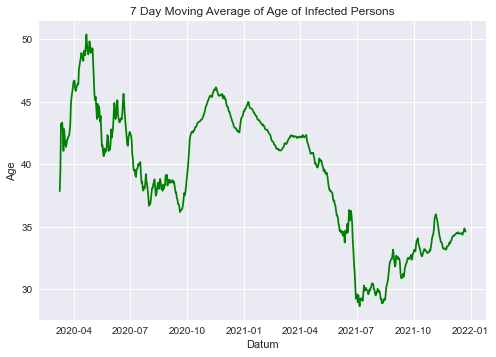

In [426]:
### Plotting 7 days moving avarage of age

#preparing x and y values
x = list(f.keys())
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in x]# unpack a list of pairs into two tuples
y = list(f.values())

#setting plot stysle
plt.style.use('seaborn')

#plot
plt.plot(good[6:], moving_average(y,7), color = "green", linestyle = "-")

#naming x and y axis
plt.xlabel('Datum') 
plt.ylabel('Age') 
  
# displaying the title
plt.title("7 Day Moving Average of Age of Infected Persons")

plt.show()